# Forecasting for Banking Using Time Series Methods, Live Classes Python notebook
this notebook...


## Live Class 1

In [5]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import statsmodels.api as sm

In [7]:
# Load the Excel file with all worksheets
file_path = r"/Users/hugo/Python/bsi_dataset.xlsx" #r"C:\Users\hbourrou\Python\Data\bsi_dataset.xlsx"

# Load the data into a dictionary of dataframes (the None option for sheet_name creates a dictionary of dataframes)
excel_data = pd.read_excel(file_path, sheet_name=None)

# Extract worksheet names and display info to make sure everything worked fine
sheet_names = list(excel_data.keys())
print(f"Found {len(sheet_names)} worksheets: {sheet_names}")

Found 6 worksheets: ['BSI', 'GDP', 'int rate short', 'int rate long', 'Comp ind syst stress', 'HICP']


### Cleaning data
Below we work on the individual dataframes to make them consistent.   
The analysis focuses on Germany, and the monthly variables (interest rates, CISS) are converted to quarterly by averaging observations within quarters.

**Note:** for this type of easy dataset, it would be cleaner to do the treatment directly in Excel (i.e. import here only the relevant variables for Germany)

In [10]:
# create a dataframe for each worksheet and clean after
for i, (sheet_name, df) in enumerate(excel_data.items()):
    locals()[f"df{i+1}"] = df

In [12]:
# Ok, let's do the dirty cleaning now
df1.head(5)

,Unnamed: 0,"Germany, Loans, Total, Euro area (changing composition), Unspecified counterpart sector","Spain, Loans, Total, Euro area (changing composition), Unspecified counterpart sector","France, Loans, Total, Euro area (changing composition), Unspecified counterpart sector","Italy, Loans, Total, Euro area (changing composition), Unspecified counterpart sector","Germany, Deposit liabilities, Total, Euro area (changing composition), Unspecified counterpart sector","Spain, Deposit liabilities, Total, Euro area (changing composition), Unspecified counterpart sector","France, Deposit liabilities, Total, Euro area (changing composition), Unspecified counterpart sector","Italy, Deposit liabilities, Total, Euro area (changing composition), Unspecified counterpart sector","Germany, Capital and reserves, World not allocated (geographically), Unspecified counterpart sector","Spain, Capital and reserves, World not allocated (geographically), Unspecified counterpart sector","France, Capital and reserves, World not allocated (geographically), Unspecified counterpart sector","Italy, Capital and reserves, World not allocated (geographically), Unspecified counterpart sector"
0,NaN,(Millions of Euro),(Millions of Euro),(Millions of Euro),(Millions of Euro),(Millions of Euro),(Millions of Euro),(Millions of Euro),(Millions of Euro),(Millions of Euro),(Millions of Euro),(Millions of Euro),(Millions of Euro)
1,1997-Q4,3415366,NaN,NaN,NaN,2987309,NaN,NaN,NaN,197963,NaN,NaN,NaN
2,1998-Q1,3435838,NaN,NaN,NaN,3005318,NaN,NaN,NaN,202938,NaN,NaN,NaN
3,1998-Q2,3517512,NaN,NaN,NaN,3064839,NaN,NaN,NaN,207787,NaN,NaN,NaN
4,1998-Q3,3566887,NaN,NaN,NaN,3088691,NaN,NaN,NaN,207969,NaN,NaN,NaN


so what has to be done:
- drop the first row
- deal with the index
- keep only the variables related to Germany and remane them appropriately

In [15]:
df1 = df1.drop(index=0).reset_index(drop=True)
df1 = df1.set_index(pd.to_datetime(df1['Unnamed: 0']))
df1.index.name = 'date'

de_columns = [col for col in df1.columns if 'Germany' in col]
df1 = df1[de_columns]

# rename the column so that match the EViews script
df1.columns = ['de_loan', 'de_dep', 'de_cap']
df1 = df1.apply(pd.to_numeric, errors='coerce') # this converts to numeric variables (not stored like this)
df1.head(5)

/var/folders/5g/45nql5kj3fsc42f1td53mt0w0000gn/T/ipykernel_12406/3571834084.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df1 = df1.set_index(pd.to_datetime(df1['Unnamed: 0']))


,de_loan,de_dep,de_cap
date,,,
1997-10-01,3415366,2987309,197963
1998-01-01,3435838,3005318,202938
1998-04-01,3517512,3064839,207787
1998-07-01,3566887,3088691,207969
1998-10-01,3698872,3237024,212630


Now we do the same thing for the other 5 data frames...

In [18]:
# df2: GDP
df2 = df2.drop(index=0).reset_index(drop=True)
df2 = df2.set_index(pd.to_datetime(df2['Unnamed: 0']))
df1.index.name = 'date'

de_columns = [col for col in df2.columns if 'Germany' in col]
df2 = df2[de_columns]
df2 = df2.rename(columns={df2.columns[0]: 'de_gdp'})
df2 = df2.apply(pd.to_numeric, errors='coerce')
df2.head(5)

/var/folders/5g/45nql5kj3fsc42f1td53mt0w0000gn/T/ipykernel_12406/245368490.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df2 = df2.set_index(pd.to_datetime(df2['Unnamed: 0']))


,de_gdp
Unnamed: 0,
1997-10-01,506217.29
1998-01-01,481205.72
1998-04-01,492703.92
1998-07-01,509263.72
1998-10-01,521496.95


In [20]:
# df3: short interest rates
# Here the data are at the monthly frequency, so we need to take care of that and average over each quarter
df3 = df3.drop(index=0).reset_index(drop=True)
df3 = df3.set_index(pd.to_datetime(df3['Unnamed: 0'], format='%Y-%m'))
df3.index.name = 'date'

de_columns = [col for col in df3.columns if 'Germany' in col]
df3 = df3[de_columns]
df3 = df3.rename(columns={df3.columns[0]: 'de_ints'})
df3 = df3.apply(pd.to_numeric, errors='coerce')
df3 = df3.resample('QE').mean()
df3.head(5)

,de_ints
date,
2000-03-31,2.730000
2000-06-30,2.730000
2000-09-30,2.743333
2000-12-31,2.743333
2001-03-31,2.740000


In [22]:
# df4: long interest rates
# Here the data are at the monthly frequency, so we need to take care of that and average over each quarter
df4 = df4.drop(index=0).reset_index(drop=True)
df4 = df4.set_index(pd.to_datetime(df4['Unnamed: 0'], format='%Y-%m'))
df4.index.name = 'date'

de_columns = [col for col in df4.columns if 'Germany' in col]
df4 = df4[de_columns]
df4 = df4.rename(columns={df4.columns[0]: 'de_intl'})
df4 = df4.apply(pd.to_numeric, errors='coerce')
df4 = df4.resample('QE').mean()
df4.head(5)

,de_intl
date,
1997-12-31,5.490000
1998-03-31,5.000000
1998-06-30,4.886667
1998-09-30,4.386667
1998-12-31,4.013333


In [24]:
# df5: 'Comp ind syst stress', also monthly
df5 = df5.drop(index=0).reset_index(drop=True)
df5 = df5.set_index(pd.to_datetime(df5['Unnamed: 0'], format='%Y-%m'))
df5.index.name = 'date'

de_columns = [col for col in df5.columns if 'Germany' in col]
df5 = df5[de_columns]
df5 = df5.rename(columns={df5.columns[0]: 'de_ciss'})
df5 = df5.apply(pd.to_numeric, errors='coerce')
df5 = df5.resample('QE').mean()
df5.head(5)

,de_ciss
date,
2000-09-30,0.108300
2000-12-31,0.105200
2001-03-31,0.082767
2001-06-30,0.089267
2001-09-30,0.058867


In [26]:
# df6: HICP, also monthly
df6 = df6.drop(index=0).reset_index(drop=True)
df6 = df6.set_index(pd.to_datetime(df6['Unnamed: 0'], format='%Y-%m'))
df6.index.name = 'date'

de_columns = [col for col in df6.columns if 'Germany' in col]
df6 = df6[de_columns]
df6 = df6.rename(columns={df6.columns[0]: 'de_hicp'})
df6 = df6.apply(pd.to_numeric, errors='coerce')
df6 = df6.resample('QE').mean()
df6.head(5)

,de_hicp
date,
1997-12-31,0.516667
1998-03-31,0.206667
1998-06-30,0.296667
1998-09-30,0.213333
1998-12-31,0.116667


In [28]:
# Finally, we merge all the dataframe to make a final one

# First, we convert all the index explicitely to quarterly to avoid bugs with dates
for df_name in ['df1', 'df2', 'df3', 'df4', 'df5', 'df6']:
    df = locals()[df_name]
    locals()[df_name].index = df.index.to_period('Q')
    
final_df = pd.concat([df1, df2, df3, df4, df5, df6], axis=1)
final_df.head(10)

,de_loan,de_dep,de_cap,de_gdp,de_ints,de_intl,de_ciss,de_hicp
1997Q4,3415366.0,2987309.0,197963.0,506217.29,NaN,5.490000,NaN,0.516667
1998Q1,3435838.0,3005318.0,202938.0,481205.72,NaN,5.000000,NaN,0.206667
1998Q2,3517512.0,3064839.0,207787.0,492703.92,NaN,4.886667,NaN,0.296667
1998Q3,3566887.0,3088691.0,207969.0,509263.72,NaN,4.386667,NaN,0.213333
1998Q4,3698872.0,3237024.0,212630.0,521496.95,NaN,4.013333,NaN,0.116667
1999Q1,3663429.0,3153883.0,218397.0,495250.00,NaN,3.863333,NaN,0.090000
1999Q2,3728913.0,3200743.0,227867.0,507670.00,NaN,4.073333,NaN,0.183333
1999Q3,3816760.0,3253088.0,232738.0,524670.00,NaN,4.866667,NaN,0.236667
1999Q4,3878472.0,3302450.0,236956.0,537290.00,NaN,5.160000,NaN,0.370000
2000Q1,3892954.0,3330627.0,241791.0,515500.00,2.73,5.460000,NaN,0.546667


### Graphical Analysis

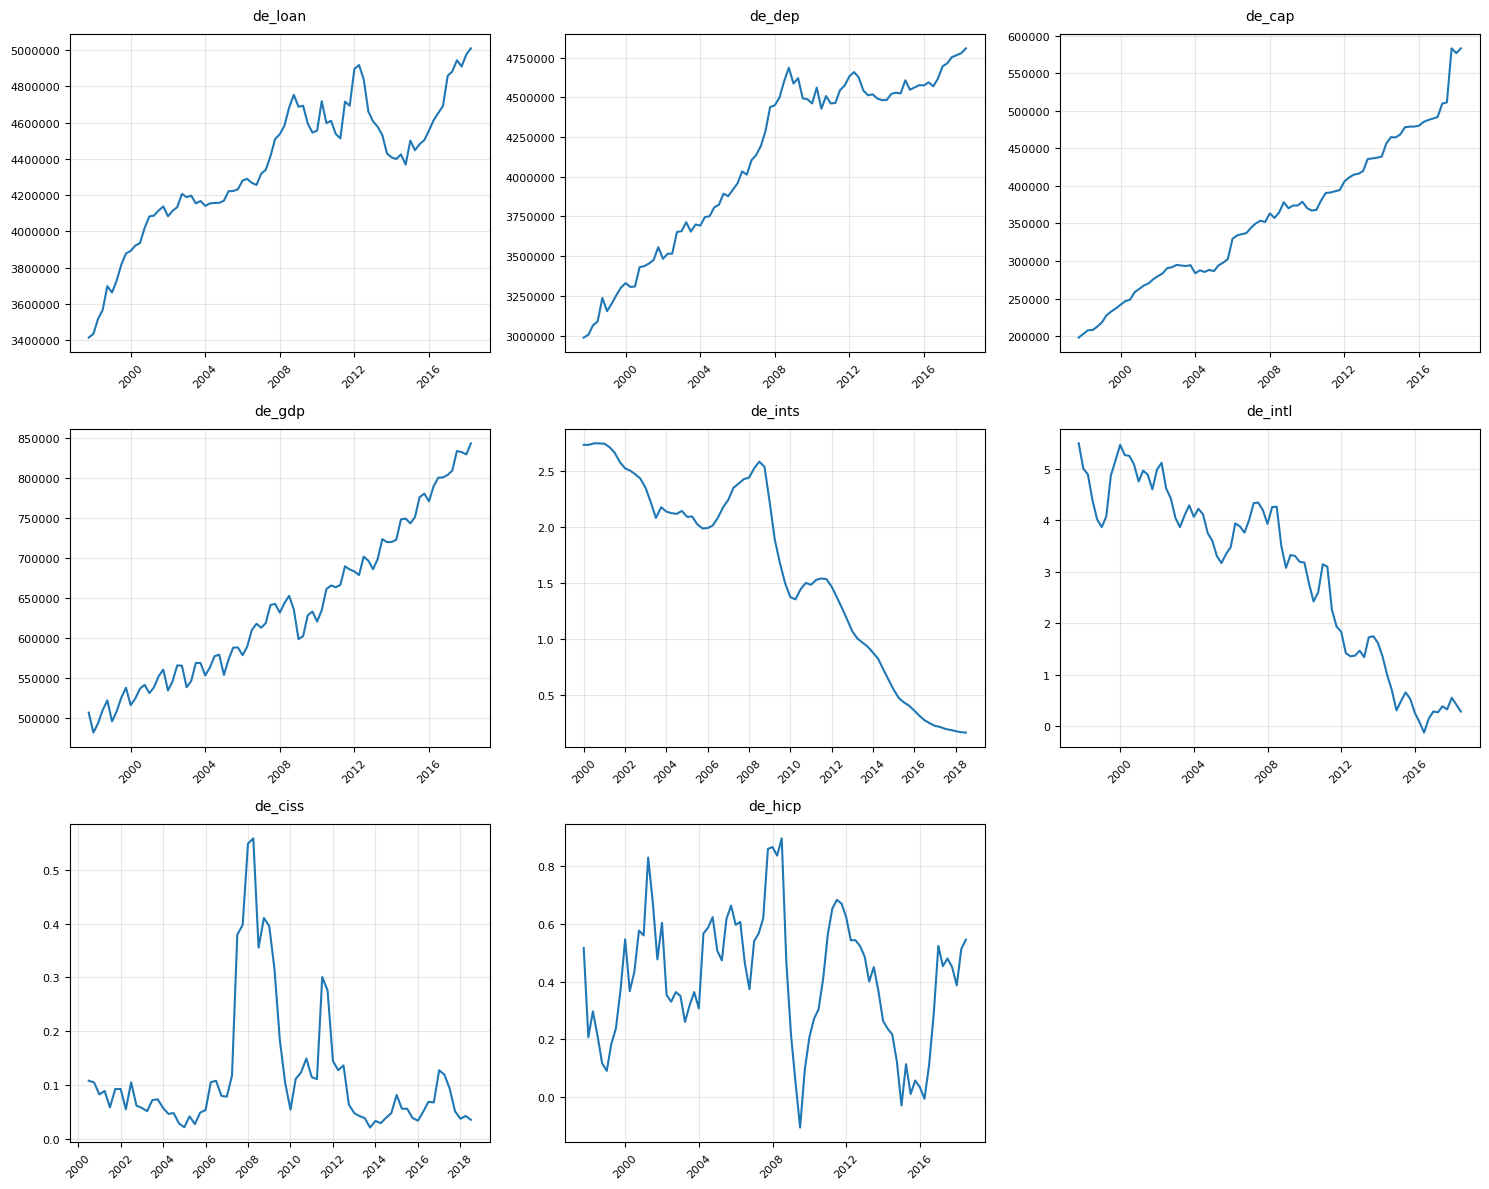

In [31]:
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes_flat = axes.flatten()
columns = final_df.columns.tolist()
for i, col in enumerate(columns):
    ax = axes_flat[i]
    x_values = final_df.index.to_timestamp() if hasattr(final_df.index, 'to_timestamp') else final_df.index
    ax.plot(x_values, final_df[col], linewidth=1.5)
    ax.set_title(col, fontsize=10, pad=10)
    ax.grid(True, alpha=0.3)
    
    ax.tick_params(axis='x', rotation=45, labelsize=8)
    ax.tick_params(axis='y', labelsize=8)
    
    ax.ticklabel_format(style='plain', axis='y')

# Hide the extra subplot (since we have 8 variables in a 3x3 grid)
axes_flat[8].set_visible(False)
plt.tight_layout()
plt.show()


#### Seasonality
There is clear seasonality in GDP, but it doesn't matter since if needed we'll work with yoy growth rates.  
What about seasonality in banking series? Graphical analysis suggests that it is not the case, but we can formally check.

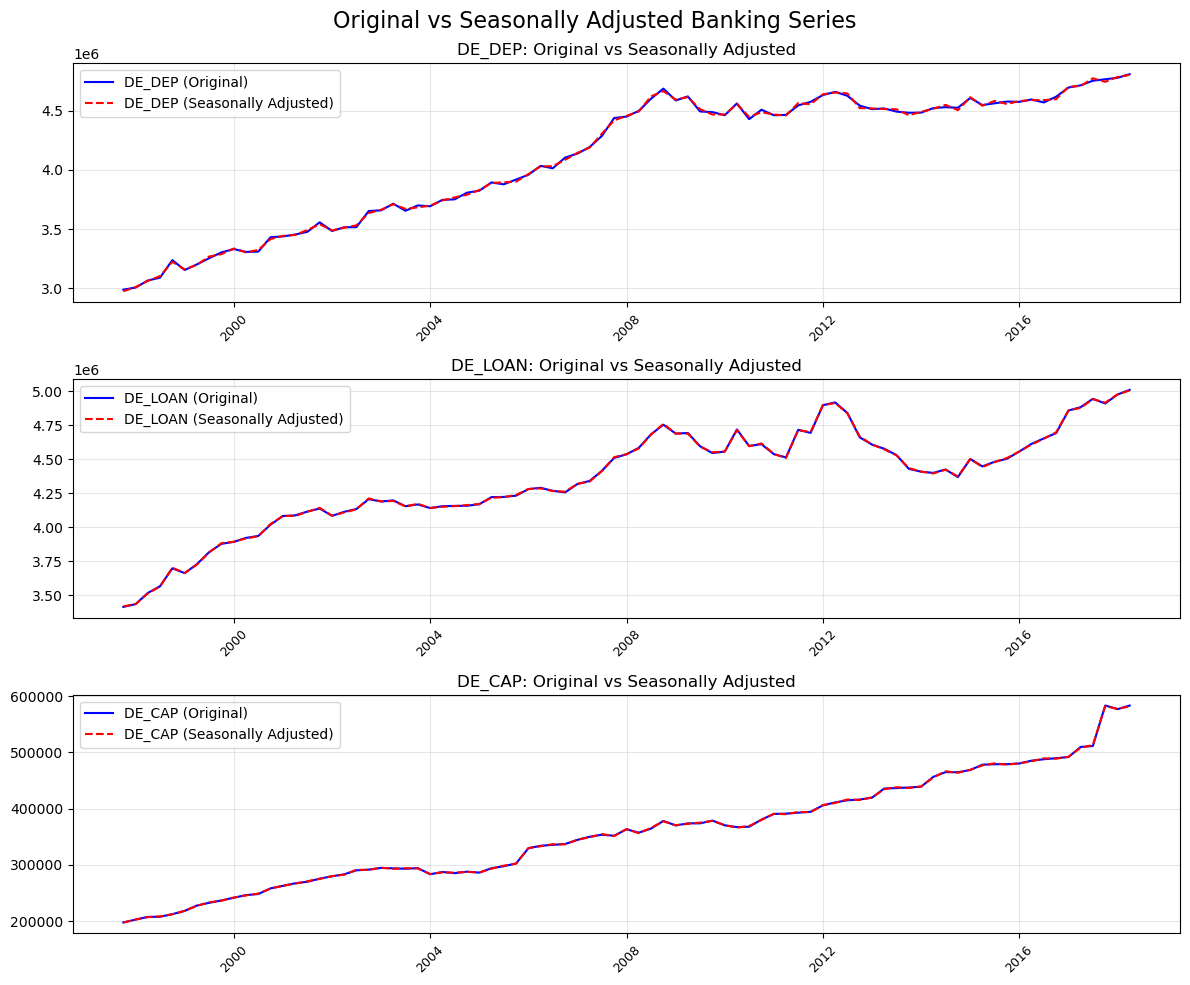

In [41]:
# Seasonal adjustement of banking series using seasonal_decompose from statsmodel
# Multiplicative seasonal adjustment (best for GDP)
from statsmodels.tsa.seasonal import seasonal_decompose

banking_vars = ['de_dep','de_loan','de_cap']
for var in banking_vars:
    decomp = seasonal_decompose(final_df[var].dropna(), model='multiplicative', period=4)
    final_df[f'{var}_sa'] = final_df[var] / decomp.seasonal

# Let's plot to see
fig, axes = plt.subplots(3, 1, figsize=(12, 10))
fig.suptitle('Original vs Seasonally Adjusted Banking Series', fontsize=16)

for i, var in enumerate(banking_vars):
    ax = axes[i]
    
    # Convert index to timestamps if needed for plotting
    x_values = final_df.index.to_timestamp() if hasattr(final_df.index, 'to_timestamp') else final_df.index
    
    # Plot original and seasonally adjusted series
    ax.plot(x_values, final_df[var], label=f'{var.upper()} (Original)', 
            linewidth=1.5, color='blue')
    ax.plot(x_values, final_df[f'{var}_sa'], label=f'{var.upper()} (Seasonally Adjusted)', 
            linewidth=1.5, color='red', linestyle='--')
    
    # Formatting
    ax.set_title(f'{var.upper()}: Original vs Seasonally Adjusted')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='x', rotation=45, labelsize=9)

plt.tight_layout()
plt.show()

#### Further graphical analysis

/var/folders/5g/45nql5kj3fsc42f1td53mt0w0000gn/T/ipykernel_12406/3774857505.py:1: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  final_df['de_gdp_g'] = final_df['de_gdp'].pct_change(4) * 100


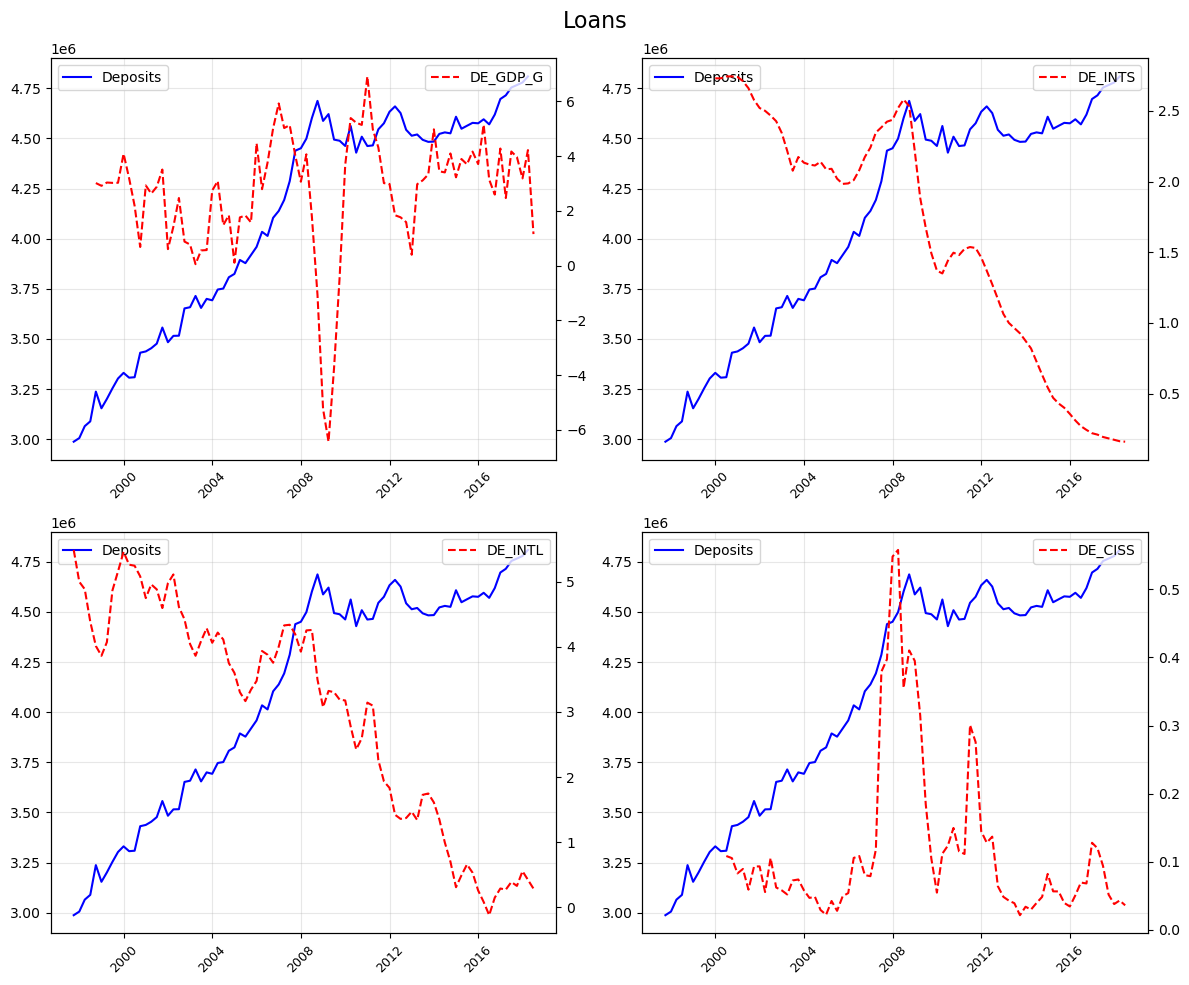

In [71]:
final_df['de_gdp_g'] = final_df['de_gdp'].pct_change(4) * 100

# Looking at relationship

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()  # flatten 2x2 grid
fig.suptitle('Loans', fontsize=16)

var_list = ['de_gdp_g','de_ints','de_intl','de_ciss']

for i, var in enumerate(var_list):
    ax = axes[i]
    
    # x-axis values
    x_values = final_df.index.to_timestamp() if hasattr(final_df.index, 'to_timestamp') else final_df.index
    
    # left y-axis
    ax.plot(x_values, final_df['de_dep'], linewidth=1.5, color='blue', label='Deposits')
    
    # right y-axis
    ax2 = ax.twinx()
    ax2.plot(x_values, final_df[var], linewidth=1.5, color='red', linestyle='--', label=f'{var.upper()}')
    
    
    # grid and formatting
    ax.legend()
    ax2.legend()
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='x', rotation=45, labelsize=9)

plt.tight_layout()
plt.show()



### ARMA Modelling
Below are the standard steps to apply the Box-Jenkins methodology
1) Stationarity check
2) ACF and PACF plots
3) Estimatioon
4) Diagnostic checks

#### 1. Stationarity checks

In [108]:
from statsmodels.tsa.stattools import adfuller

# Let's try different specifications
specs = [('n', 'No constant, no trend'), 
         ('c', 'Constant'), 
         ('ct', 'Constant and trend')]

# Run tests and collect results
results = []
for spec_code, spec_name in specs:
    adf_result = adfuller(final_df['de_loan'].dropna(), regression=spec_code, autolag='AIC')
    results.append({
        'Specification': spec_name,
        'ADF Statistic': f"{adf_result[0]:.4f}",
        'P-value': f"{adf_result[1]:.4f}",
        'Critical Value (99%) ': f"{adf_result[4]['1%']:.4f}"
    })

# Create results table
results_df = pd.DataFrame(results)
print("ADF Test Results for loan series")
print("=" * 70)
print(results_df.to_string(index=False))

print("\nNote: H0 = Unit root (non-stationary), H1 = Stationary")


ADF Test Results for loan series
        Specification ADF Statistic P-value Critical Value (99%) 
No constant, no trend        2.4738  0.9979               -2.5935
             Constant       -1.6931  0.4347               -3.5149
   Constant and trend       -2.8372  0.1836               -4.0766

Note: H0 = Unit root (non-stationary), H1 = Stationary


So we can't reject H0 for the three specifications $\Rightarrow$ evidence of a unit root and series needs first differencing

In [114]:
# Let's create the series in first differences and check whether it's stationary
final_df['de_loan_d'] = final_df['de_loan'].diff()

# Now we run the ADF tests again
results = []
for spec_code, spec_name in specs:
    adf_result = adfuller(final_df['de_loan_d'].dropna(), regression=spec_code, autolag='AIC')
    results.append({
        'Specification': spec_name,
        'ADF Statistic': f"{adf_result[0]:.4f}",
        'P-value': f"{adf_result[1]:.4f}",
        'Critical Value (99%) ': f"{adf_result[4]['1%']:.4f}"
    })

results_df = pd.DataFrame(results)
print("ADF Test Results for loan series in first differences")
print("=" * 70)
print(results_df.to_string(index=False))


ADF Test Results for loan series in first differences
        Specification ADF Statistic P-value Critical Value (99%) 
No constant, no trend       -4.4276  0.0000               -2.5943
             Constant       -4.7988  0.0001               -3.5149
   Constant and trend       -4.7793  0.0005               -4.0766


So we reject the null of a unit root for all specification $\Rightarrow$ series is stationary.  
However, formally conducting the test is not necessary. Usually, visual inspection is largely enough. Let's look at the series:

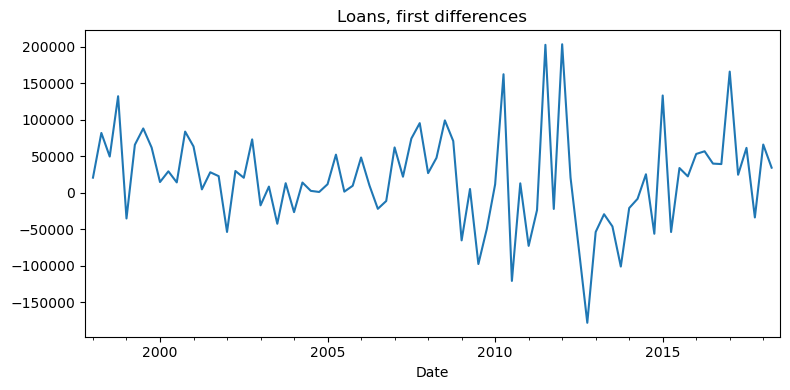

In [127]:
plt.figure(figsize=(8,4))
final_df['de_loan_d'].plot(title="Loans, first differences")
plt.xlabel("Date")
plt.tight_layout()
plt.show()


In [138]:
# Now we do the exact same thing for deposits
results = []
for spec_code, spec_name in specs:
    adf_result = adfuller(final_df['de_dep'].dropna(), regression=spec_code, autolag='AIC')
    results.append({
        'Specification': spec_name,
        'ADF Statistic': f"{adf_result[0]:.4f}",
        'P-value': f"{adf_result[1]:.4f}",
        'Critical Value (99%) ': f"{adf_result[4]['1%']:.4f}"
    })

# Create results table
results_df = pd.DataFrame(results)
print("ADF Test Results for deposits series")
print("=" * 70)
print(results_df.to_string(index=False))

ADF Test Results for deposits series
        Specification ADF Statistic P-value Critical Value (99%) 
No constant, no trend        2.4289  0.9975               -2.5943
             Constant       -1.6349  0.4649               -3.5183
   Constant and trend       -1.5138  0.8244               -4.0766


ADF Test Results for deposits series in first differences
        Specification ADF Statistic P-value Critical Value (99%) 
No constant, no trend       -2.6348  0.0082               -2.5954
             Constant       -5.2773  0.0000               -3.5149
   Constant and trend       -3.7101  0.0217               -4.0814





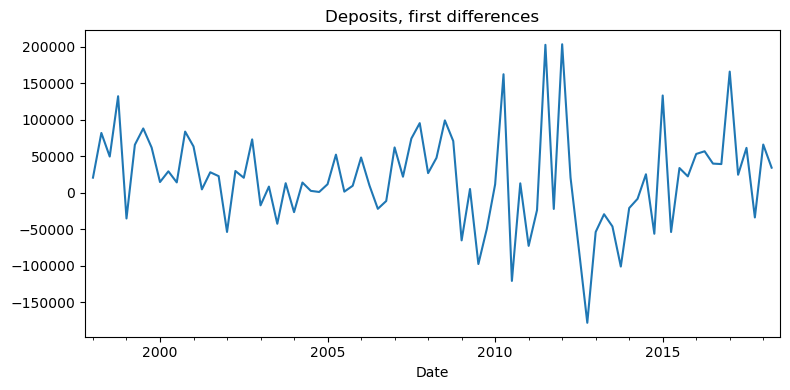

In [140]:
final_df['de_dep_d'] = final_df['de_dep'].diff()

# Now we run the ADF tests again
results = []
for spec_code, spec_name in specs:
    adf_result = adfuller(final_df['de_dep_d'].dropna(), regression=spec_code, autolag='AIC')
    results.append({
        'Specification': spec_name,
        'ADF Statistic': f"{adf_result[0]:.4f}",
        'P-value': f"{adf_result[1]:.4f}",
        'Critical Value (99%) ': f"{adf_result[4]['1%']:.4f}"
    })

results_df = pd.DataFrame(results)
print("ADF Test Results for deposits series in first differences")
print("=" * 70)
print(results_df.to_string(index=False))
print('\n\n')

# plot
plt.figure(figsize=(8,4))
final_df['de_loan_d'].plot(title="Deposits, first differences")
plt.xlabel("Date")
plt.tight_layout()
plt.show()

#### 2. Identification and estimation
Remember:
- For an MA(q) process, the ACF will cut sharply after q lags. For an AR(p) process, we'll see a gradual decay of the ACF
- For an AR(p) process, the PACF will cut sharply after p lags, while it will gradually decay for an MA process
- In many applications (as here), this is not as simple

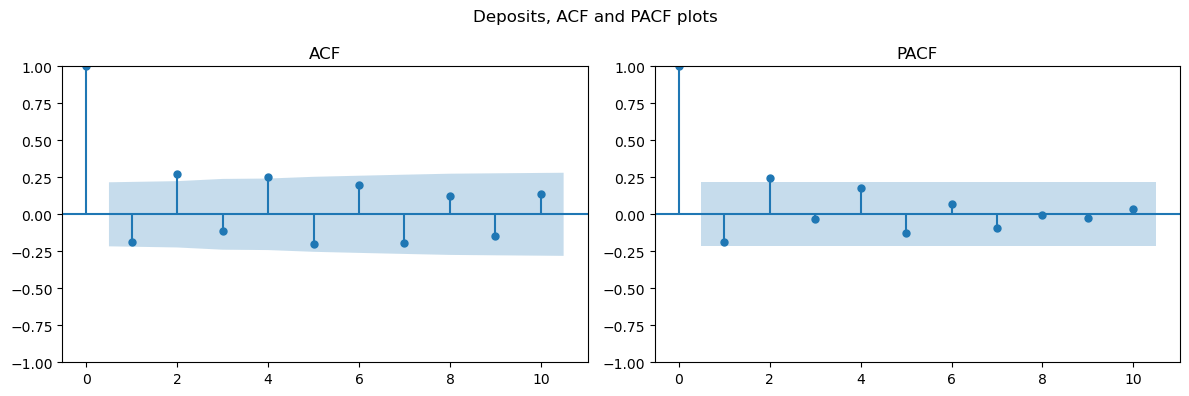

In [147]:
# we begin with ACF and PACF plots to determine the possible order of the AR and MA components
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle('Deposits, ACF and PACF plots')
# ACF plot
plot_acf(final_df['de_dep_d'].dropna(), lags=10, ax=axes[0], title='ACF')

# PACF plot
plot_pacf(final_df['de_dep_d'].dropna(), lags=10, ax=axes[1], title='PACF')

plt.tight_layout()
plt.show()

So we see neither clear cutoff nor asymptotical decay in both the ACF or PACF $\Rightarrow$ inconclusive results.  

We then move to "trial and error". Because we're dealing with quarterly data, we will try AR(4) and MA(4) specifications.

In [159]:
from statsmodels.tsa.arima.model import ARIMA

# AR(4)
series = final_df['de_dep_d'].dropna()
model = ARIMA(series, order=(4,0,0))  
result = model.fit()

print(result.summary())

                               SARIMAX Results                                
Dep. Variable:               de_dep_d   No. Observations:                   82
Model:                 ARIMA(4, 0, 0)   Log Likelihood               -1006.771
Date:                Wed, 24 Sep 2025   AIC                           2025.543
Time:                        17:28:27   BIC                           2039.983
Sample:                    03-31-1998   HQIC                          2031.340
                         - 06-30-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.221e+04   7738.770      2.871      0.004    7046.985    3.74e+04
ar.L1         -0.1275      0.112     -1.137      0.255      -0.347       0.092
ar.L2          0.1940      0.108      1.793      0.0

To note about the results:
- Ljung-Box test: HO: residuals are **not** autocorrelated. we can't reject, so OK
- Heteroskedasticity: H0 is homeskedastic variance. we can't reject, so OK
- Jarque-Bera is for normality of residuals, H0 is that they are normally distributed. we can't reject, so OK
$\Rightarrow$ the residuals pass the diagnostic checks.

However, many of the lags are not significant, se we may want to try a more parsimonious spec.

In [164]:
# MA(4)
series = final_df['de_dep_d'].dropna()
model = ARIMA(series, order=(0,0,4))  
result = model.fit()

print(result.summary())

                               SARIMAX Results                                
Dep. Variable:               de_dep_d   No. Observations:                   82
Model:                 ARIMA(0, 0, 4)   Log Likelihood               -1007.985
Date:                Wed, 24 Sep 2025   AIC                           2027.971
Time:                        17:33:51   BIC                           2042.411
Sample:                    03-31-1998   HQIC                          2033.769
                         - 06-30-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.221e+04   7774.544      2.857      0.004    6976.869    3.75e+04
ma.L1         -0.1219      0.114     -1.069      0.285      -0.345       0.102
ma.L2          0.1947      0.128      1.517      0.1

That's also pretty bad. Let's try ARMA(1,1)

In [168]:
# AR(4)
series = final_df['de_dep_d'].dropna()
model = ARIMA(series, order=(1,0,1))  
result = model.fit()

print(result.summary())

                               SARIMAX Results                                
Dep. Variable:               de_dep_d   No. Observations:                   82
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -1005.756
Date:                Wed, 24 Sep 2025   AIC                           2019.511
Time:                        17:35:00   BIC                           2029.138
Sample:                    03-31-1998   HQIC                          2023.376
                         - 06-30-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.221e+04   6013.422      3.694      0.000    1.04e+04     3.4e+04
ar.L1         -0.9831      0.026    -37.334      0.000      -1.035      -0.931
ma.L1          0.9111      0.083     10.975      0.0

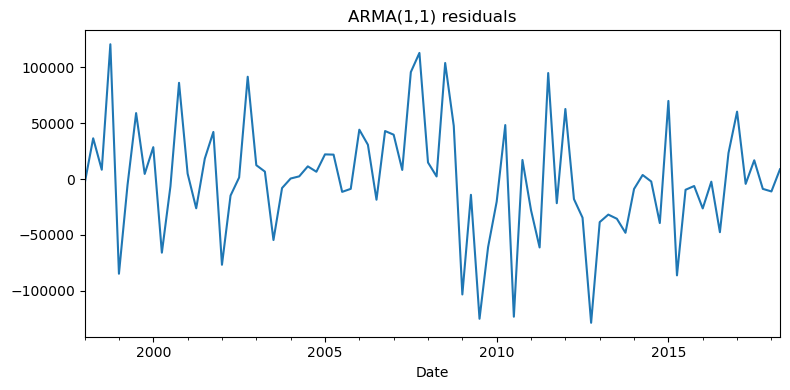

In [170]:
resid = result.resid

plt.figure(figsize=(8,4))
resid.plot(title="ARMA(1,1) residuals")
plt.xlabel("Date")
plt.tight_layout()
plt.show()

## Live Class 2

In [ ]:
# 150 - 65%
# x   - 100%

In [3]:
150/.7

214.2857142857143